# Data-Generate

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

# 设置随机种子以确保可重复性
np.random.seed(42)
torch.manual_seed(42)

# 参数设置
delta_t = 0.05  # 时间步长
N = 2 * 10**7   # 总步数
d = 2           # 维度（二维 SDE）
batch_size = 10000  # 批处理大小

# 检查是否有可用的CUDA设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 定义 phi(x1, x2)
def phi(x):
    x1, x2 = x[:, 0], x[:, 1]
    return 1 + (2/15) * (4 * x1**2 - x1 * x2 + x2**2)

# 定义漂移 a(x)
def a(x):
    x1, x2 = x[:, 0], x[:, 1]
    a1 = -1.5 * x1 + x2
    a2 = 0.25 * x1 - 1.5 * x2
    return torch.stack([a1, a2], dim=1)

# 定义扩散 b(x)
def b(x):
    batch_size = x.shape[0]
    sqrt_phi_val = torch.sqrt(phi(x))
    
    # 创建一个批处理的2x2矩阵
    b_matrix = torch.zeros(batch_size, d, d, device=device)
    
    # 填充矩阵
    b_matrix[:, 0, 0] = sqrt_phi_val
    b_matrix[:, 0, 1] = 0
    b_matrix[:, 1, 0] = -sqrt_phi_val * (11 / 8)
    b_matrix[:, 1, 1] = (torch.sqrt(torch.tensor(255.0, device=device)) / 8) * sqrt_phi_val
    
    return b_matrix

# 使用批处理和GPU加速的Euler-Maruyama方法
def simulate_sde_batched():
    # 结果数组，存储在CPU上
    x_result = torch.zeros((N, d), dtype=torch.float32)
    x_result[0] = torch.tensor([0.0, 0.0])  # 初始点
    
    # 当前状态，初始为[0,0]
    x_current = torch.zeros((batch_size, d), device=device)
    
    # 使用批处理进行模拟
    for n in tqdm(range(0, N-1, batch_size)):
        # 确定当前批次的实际大小（最后一批可能小于batch_size）
        current_batch_size = min(batch_size, N-1-n)
        
        if current_batch_size < batch_size:
            x_current = x_current[:current_batch_size]
        
        # 漂移项
        drift = a(x_current) * delta_t
        
        # 扩散项
        diffusion_matrices = b(x_current)  # 形状: [batch_size, d, d]
        noise = torch.randn(current_batch_size, d, device=device)  # 标准正态噪声
        
        # 对每个样本应用扩散矩阵
        diffusion = torch.sqrt(torch.tensor(delta_t, device=device)) * torch.bmm(diffusion_matrices, noise.unsqueeze(-1)).squeeze(-1)
        
        # 更新状态
        x_next = x_current + drift + diffusion
        
        # 将结果转移到CPU并存储
        x_result[n+1:n+1+current_batch_size] = x_next.cpu()
        
        # 更新当前状态为新状态（用于下一个批次）
        if n + batch_size < N - 1:
            x_current = x_next.clone()
        
    return x_result

# 计时开始
start_time = time.time()

# 执行模拟
x = simulate_sde_batched()

# 计时结束
end_time = time.time()
print(f"模拟耗时: {end_time - start_time:.2f} 秒")

# 将结果转换为numpy数组进行后续分析
x_np = x.numpy()

# 检查采样点在 Omega 内的比例
Omega_x1 = [-4, 4]  # x1 的范围
Omega_x2 = [-6, 6]  # x2 的范围
in_Omega = np.sum((x_np[:, 0] >= Omega_x1[0]) & (x_np[:, 0] <= Omega_x1[1]) &
                  (x_np[:, 1] >= Omega_x2[0]) & (x_np[:, 1] <= Omega_x2[1]))
percentage = (in_Omega / N) * 100
print(f"Percentage of points in Omega: {percentage:.2f}%")

# 可视化采样点（取前 10,000 个点以加快绘图）
plt.figure(figsize=(8, 6))
plt.scatter(x_np[:10000, 0], x_np[:10000, 1], s=1, alpha=0.5)
plt.xlim(Omega_x1)
plt.ylim(Omega_x2)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Sampled Points from CUDA-accelerated EM Method')
plt.grid(True)
plt.savefig('sde_samples_cuda.png')
plt.show()

# 保存数据（可选）
np.save('sde_data_cuda.npy', x_np) 

# 测试数据

文件大小: 152.59 MB
数据形状: (20000000, 2)
数据类型: float32
数据总数: 40000000
维度数量: 2

数据统计信息:
最小值: [-45.830338 -98.97168 ]
最大值: [59.15394 64.02583]
均值: [0.00324247 0.00250749]
标准差: [1.1309026 1.6522223]

前10个样本:
[[ 0.          0.        ]
 [ 0.04338392  0.9610907 ]
 [-0.0384716   0.38217485]
 [-0.4303087   0.32731214]
 [-0.14521939 -0.3527918 ]
 [ 0.11805645 -0.57907677]
 [-0.37166274 -0.10440894]
 [-0.02069925  0.0906523 ]
 [-0.2505364   0.85002404]
 [-0.15977126  0.32044262]]


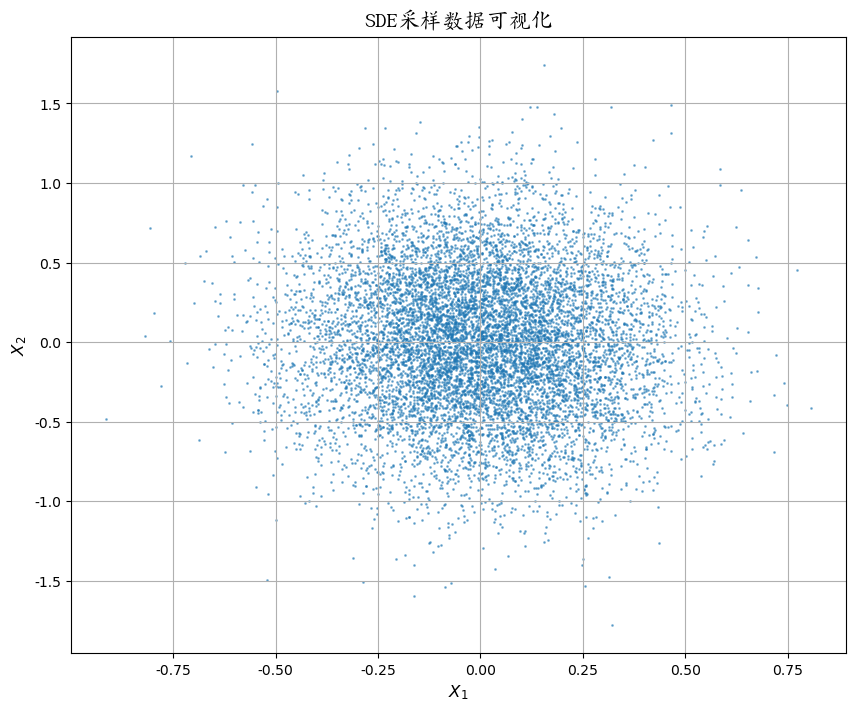

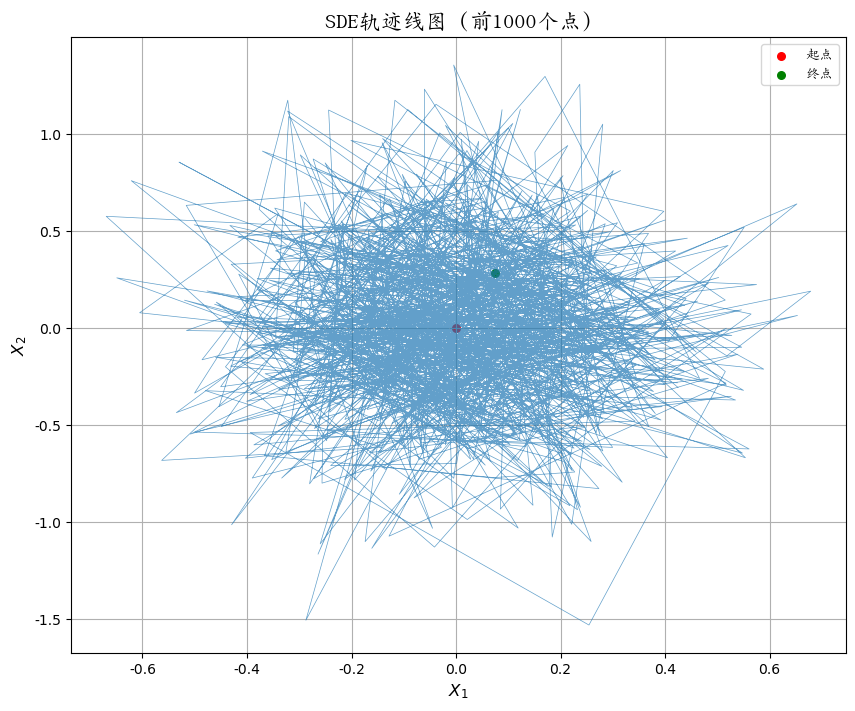

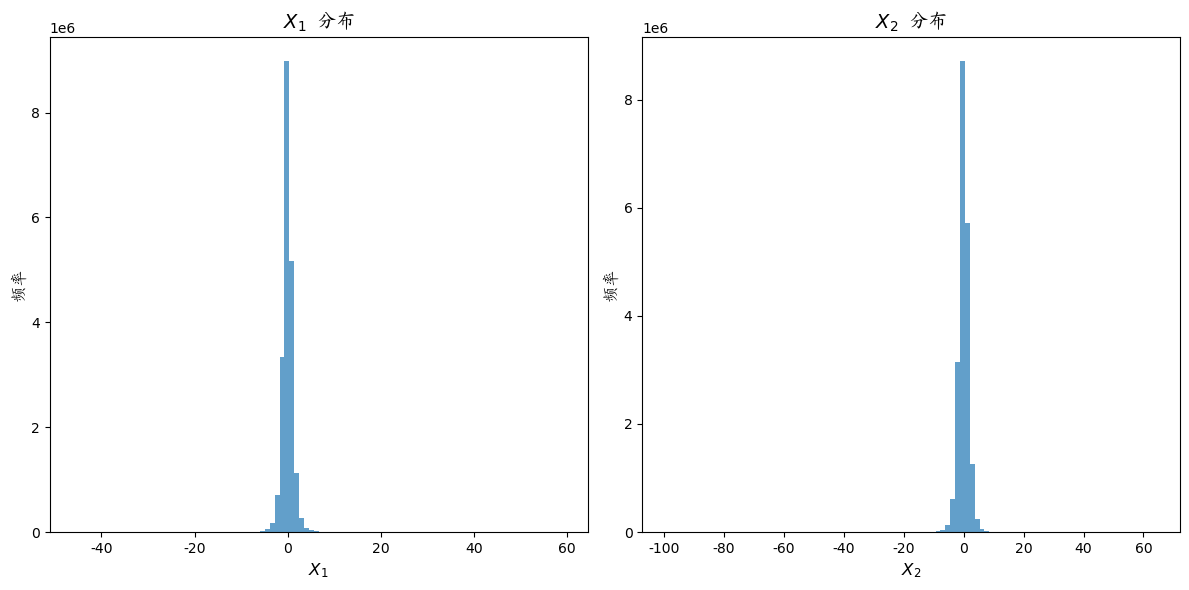

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os
import logging

# 禁用matplotlib字体管理器的警告
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

# 设置中文字体
ukai_font = fm.FontProperties(fname='/usr/share/fonts/truetype/arphic/ukai.ttc')

# 显示文件信息
file_path = 'sde_data_cuda.npy'
file_size_mb = os.path.getsize(file_path) / (1024 * 1024)
print(f"文件大小: {file_size_mb:.2f} MB")

# 读取数据
data = np.load(file_path)

# 显示数据详情
print(f"数据形状: {data.shape}")
print(f"数据类型: {data.dtype}")
print(f"数据总数: {data.size}")
print(f"维度数量: {data.ndim}")

# 显示数据统计信息
print("\n数据统计信息:")
print(f"最小值: {data.min(axis=0)}")
print(f"最大值: {data.max(axis=0)}")
print(f"均值: {data.mean(axis=0)}")
print(f"标准差: {data.std(axis=0)}")

# 显示数据前10个样本
print("\n前10个样本:")
print(data[:10])

# 可视化采样点（取前10000个点）
plt.figure(figsize=(10, 8))
plt.scatter(data[:10000, 0], data[:10000, 1], s=1, alpha=0.5)
plt.xlabel('$X_1$', fontproperties=ukai_font, fontsize=12)
plt.ylabel('$X_2$', fontproperties=ukai_font, fontsize=12)
plt.title('SDE采样数据可视化', fontproperties=ukai_font, fontsize=16)
plt.grid(True)
plt.show()

# 绘制轨迹线图（前1000个点）
plt.figure(figsize=(10, 8))
plt.plot(data[:1000, 0], data[:1000, 1], '-', linewidth=0.5, alpha=0.7)
plt.scatter(data[0, 0], data[0, 1], color='red', s=30, label='起点')
plt.scatter(data[999, 0], data[999, 1], color='green', s=30, label='终点')
plt.xlabel('$X_1$', fontproperties=ukai_font, fontsize=12)
plt.ylabel('$X_2$', fontproperties=ukai_font, fontsize=12)
plt.title('SDE轨迹线图 (前1000个点)', fontproperties=ukai_font, fontsize=16)
plt.legend(prop=ukai_font)
plt.grid(True)
plt.show()

# 绘制数据分布直方图
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(data[:, 0], bins=100, alpha=0.7)
plt.title('$X_1$ 分布', fontproperties=ukai_font, fontsize=14)
plt.xlabel('$X_1$', fontproperties=ukai_font, fontsize=12)
plt.ylabel('频率', fontproperties=ukai_font, fontsize=12)

plt.subplot(1, 2, 2)
plt.hist(data[:, 1], bins=100, alpha=0.7)
plt.title('$X_2$ 分布', fontproperties=ukai_font, fontsize=14)
plt.xlabel('$X_2$', fontproperties=ukai_font, fontsize=12)
plt.ylabel('频率', fontproperties=ukai_font, fontsize=12)

plt.tight_layout()
plt.show()

In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import time
import os
from tqdm import tqdm

# 设置随机种子以保证结果可复现
torch.manual_seed(42)
np.random.seed(42)

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 加载数据
data_path = "sde_data_cuda.npy"
data = np.load(data_path)
print(f"数据形状: {data.shape}")

# 定义计算域
omega = [[-4, 4], [-6, 6]]
print(f"计算域 Omega: {omega}")

# 统计在计算域内的数据点比例
in_domain = np.logical_and(
    np.logical_and(data[:, 0] >= omega[0][0], data[:, 0] <= omega[0][1]),
    np.logical_and(data[:, 1] >= omega[1][0], data[:, 1] <= omega[1][1])
)
percentage_in_domain = np.mean(in_domain) * 100
print(f"计算域内的数据点比例: {percentage_in_domain:.2f}%")

# 过滤在计算域内的数据
data_in_domain = data[in_domain]
print(f"计算域内的数据形状: {data_in_domain.shape}")

# 定义时间步长
delta_t = 0.05

# 计算 y^n = (x^{n+1} - x^n) / delta_t
X_data = data[:-1]  # x^n
X_next = data[1:]   # x^{n+1}
Y_data = (X_next - X_data) / delta_t  # y^n

# 将数据转换为 PyTorch 张量
X_tensor = torch.FloatTensor(X_data).to(device)
Y_tensor = torch.FloatTensor(Y_data).to(device)

# 创建数据集和数据加载器
dataset = TensorDataset(X_tensor, Y_tensor)
batch_size = 10000
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# ------------------ 定义真实的漂移和扩散系数 ------------------
def true_drift(x):
    """真实的漂移系数"""
    a1 = -1.5 * x[:, 0] + x[:, 1]
    a2 = 0.25 * x[:, 0] - 1.5 * x[:, 1]
    return torch.stack([a1, a2], dim=1)

def phi(x):
    """辅助函数 phi"""
    return 1 + (2/15) * (4 * x[:, 0]**2 - x[:, 0] * x[:, 1] + x[:, 1]**2)

def true_diffusion(x):
    """真实的扩散系数矩阵 BB^T"""
    phi_val = phi(x)
    b11 = phi_val
    b12 = -11/8 * phi_val
    b22 = ((-11/8)**2 + (np.sqrt(255)/8)**2) * phi_val
    
    # 构建 BB^T 矩阵
    b11_tensor = b11.view(-1, 1, 1)
    b12_tensor = b12.view(-1, 1, 1)
    b22_tensor = b22.view(-1, 1, 1)
    
    zeros = torch.zeros_like(b11_tensor)
    
    # 第一行
    row1 = torch.cat([b11_tensor, b12_tensor], dim=2)
    # 第二行
    row2 = torch.cat([b12_tensor, b22_tensor], dim=2)
    
    # 组合成矩阵
    return torch.cat([row1, row2], dim=1)

def true_density(x):
    """真实的平稳密度函数"""
    phi_val = phi(x)
    return (2 / (np.pi * np.sqrt(15))) * (phi_val ** (-3))


# ------------------ 定义 ResNet 神经网络 ------------------
class MishActivation(nn.Module):
    """Mish激活函数"""
    def forward(self, x):
        return x * torch.tanh(nn.functional.softplus(x))

class ResBlock(nn.Module):
    """残差块"""
    def __init__(self, dim):
        super(ResBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            MishActivation(),
            nn.Linear(dim, dim)
        )
        self.activation = MishActivation()
        
    def forward(self, x):
        return self.activation(x + self.block(x))

class ResNet(nn.Module):
    """残差网络"""
    def __init__(self, input_dim, output_dim, hidden_dim=50, num_blocks=6):
        super(ResNet, self).__init__()
        
        self.input_layer = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            MishActivation()
        )
        
        self.res_blocks = nn.ModuleList([
            ResBlock(hidden_dim) for _ in range(num_blocks)
        ])
        
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.input_layer(x)
        for block in self.res_blocks:
            x = block(x)
        return self.output_layer(x)


# ------------------ 训练漂移系数网络 ------------------
def train_drift_network():
    """训练漂移系数网络"""
    print("训练漂移系数网络...")
    
    # 为每个维度创建一个网络
    drift_networks = []
    for i in range(2):  # 2维系统
        net = ResNet(input_dim=2, output_dim=1).to(device)
        drift_networks.append(net)
    
    # 优化器
    optimizers = [
        optim.Adam(net.parameters(), lr=1e-4) for net in drift_networks
    ]
    
    # 训练参数
    total_iterations = 20000
    
    # 损失历史
    loss_history = [[] for _ in range(2)]
    
    for iteration in range(total_iterations):
        # 学习率余弦衰减
        lr = 1e-4 * 0.5 * (np.cos(np.pi * iteration / total_iterations) + 1)
        for optimizer in optimizers:
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
        
        # 训练一个批次
        for batch_idx, (x, y) in enumerate(dataloader):
            for i in range(2):  # 每个维度
                optimizers[i].zero_grad()
                
                # 前向传播
                y_pred = drift_networks[i](x)
                loss = torch.mean((y[:, i].view(-1, 1) - y_pred) ** 2)
                
                # 反向传播和优化
                loss.backward()
                optimizers[i].step()
                
                loss_history[i].append(loss.item())
            
            # 每个 epoch 只训练一个批次
            break
        
        # 打印训练进度
        if (iteration + 1) % 1000 == 0:
            print(f"Iteration [{iteration+1}/{total_iterations}], " 
                  f"Loss1: {loss_history[0][-1]:.6f}, "
                  f"Loss2: {loss_history[1][-1]:.6f}")
    
    # 保存训练好的模型
    for i, net in enumerate(drift_networks):
        torch.save(net.state_dict(), f"drift_network_{i}.pth")
    
    return drift_networks

# ------------------ 估计漂移系数 ------------------
def a_NN(x, drift_networks):
    """估计的漂移系数"""
    with torch.no_grad():
        a1 = drift_networks[0](x)
        a2 = drift_networks[1](x)
        return torch.cat([a1, a2], dim=1)

# ------------------ 训练扩散系数网络 ------------------
def train_diffusion_network(drift_networks):
    """训练扩散系数网络"""
    print("训练扩散系数网络...")
    
    # 为每个 B_ij 创建一个网络
    diffusion_networks = []
    for i in range(2):
        for j in range(2): 
            net = ResNet(input_dim=2, output_dim=1).to(device)
            diffusion_networks.append(net)
    
    # 优化器
    optimizers = [
        optim.Adam(net.parameters(), lr=1e-4) for net in diffusion_networks
    ]
    
    # 训练参数
    total_iterations = 20000
    
    # 损失历史
    loss_history = [[] for _ in range(4)]
    
    for iteration in range(total_iterations):
        # 学习率余弦衰减
        lr = 1e-4 * 0.5 * (np.cos(np.pi * iteration / total_iterations) + 1)
        for optimizer in optimizers:
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
        
        # 训练一个批次
        for batch_idx, (x, y) in enumerate(dataloader):
            for i in range(2):
                for j in range(2):
                    idx = i * 2 + j
                    optimizers[idx].zero_grad()
                    
                    # 计算残差
                    a_pred = a_NN(x, drift_networks)
                    residual_i = y[:, i] - a_pred[:, i]
                    residual_j = y[:, j] - a_pred[:, j]
                    
                    # 计算 residual_i * residual_j
                    residual_product = residual_i * residual_j
                    
                    # 前向传播
                    b_pred = diffusion_networks[idx](x)
                    
                    # 损失函数: |residual_i * residual_j - (1/delta_t) * B_NN|^2
                    loss = torch.mean((residual_product.view(-1, 1) - (1/delta_t) * b_pred) ** 2)
                    
                    # 反向传播和优化
                    loss.backward()
                    optimizers[idx].step()
                    
                    loss_history[idx].append(loss.item())
            
            # 每个 epoch 只训练一个批次
            break
        
        # 打印训练进度
        if (iteration + 1) % 1000 == 0:
            avg_loss = sum([loss_history[i][-1] for i in range(4)]) / 4
            print(f"Iteration [{iteration+1}/{total_iterations}], Avg Loss: {avg_loss:.6f}")
    
    # 保存训练好的模型
    for i, net in enumerate(diffusion_networks):
        torch.save(net.state_dict(), f"diffusion_network_{i}.pth")
    
    return diffusion_networks

# ------------------ 估计扩散系数 ------------------
def B_NN(x, diffusion_networks):
    """估计的扩散系数矩阵"""
    with torch.no_grad():
        B = torch.zeros(x.shape[0], 2, 2, device=x.device)
        for i in range(2):
            for j in range(2):
                idx = i * 2 + j
                B[:, i, j] = diffusion_networks[idx](x).squeeze()
        return B

# ------------------ 评估漂移和扩散系数的估计精度 ------------------
def evaluate_coefficients(drift_networks, diffusion_networks):
    """评估漂移和扩散系数的估计精度"""
    print("评估漂移和扩散系数的估计精度...")
    
    # 生成均匀网格点作为测试点
    n_grid = 100
    x1 = np.linspace(omega[0][0], omega[0][1], n_grid)
    x2 = np.linspace(omega[1][0], omega[1][1], n_grid)
    X1, X2 = np.meshgrid(x1, x2)
    
    # 将网格点转换为张量
    grid_points = np.stack([X1.flatten(), X2.flatten()], axis=1)
    grid_tensor = torch.FloatTensor(grid_points).to(device)
    
    # 计算真实值
    true_a = true_drift(grid_tensor).cpu().numpy()
    true_B = true_diffusion(grid_tensor).cpu().numpy()
    
    # 计算估计值
    with torch.no_grad():
        estimated_a = a_NN(grid_tensor, drift_networks).cpu().numpy()
        estimated_B = B_NN(grid_tensor, diffusion_networks).cpu().numpy()
    
    # 计算相对 L2 误差
    a_error = np.sqrt(np.sum((true_a - estimated_a)**2)) / np.sqrt(np.sum(true_a**2))
    B_error = np.sqrt(np.sum((true_B - estimated_B)**2)) / np.sqrt(np.sum(true_B**2))
    
    print(f"漂移系数的相对 L2 误差: {a_error:.4e}")
    print(f"扩散系数的相对 L2 误差: {B_error:.4e}")
    
    # 可视化第一个分量
    plt.figure(figsize=(15, 5))
    
    # 真实漂移系数的第一个分量
    plt.subplot(1, 3, 1)
    plt.contourf(X1, X2, true_a[:, 0].reshape(n_grid, n_grid))
    plt.colorbar()
    plt.title("True Drift $a_1(x)$")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    
    # 估计的漂移系数的第一个分量
    plt.subplot(1, 3, 2)
    plt.contourf(X1, X2, estimated_a[:, 0].reshape(n_grid, n_grid))
    plt.colorbar()
    plt.title("Estimated Drift $a_{NN,1}(x)$")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    
    # 差异
    plt.subplot(1, 3, 3)
    plt.contourf(X1, X2, (true_a[:, 0] - estimated_a[:, 0]).reshape(n_grid, n_grid))
    plt.colorbar()
    plt.title("Difference $a_1(x) - a_{NN,1}(x)$")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    
    plt.tight_layout()
    plt.savefig("drift_comparison.png")
    
    # 可视化扩散系数的第一个对角元素
    plt.figure(figsize=(15, 5))
    
    # 真实扩散系数的 (1,1) 元素
    plt.subplot(1, 3, 1)
    plt.contourf(X1, X2, true_B[:, 0, 0].reshape(n_grid, n_grid))
    plt.colorbar()
    plt.title("True Diffusion $(BB^T)_{11}(x)$")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    
    # 估计的扩散系数的 (1,1) 元素
    plt.subplot(1, 3, 2)
    plt.contourf(X1, X2, estimated_B[:, 0, 0].reshape(n_grid, n_grid))
    plt.colorbar()
    plt.title("Estimated Diffusion $(B_{NN})_{11}(x)$")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    
    # 差异
    plt.subplot(1, 3, 3)
    plt.contourf(X1, X2, (true_B[:, 0, 0] - estimated_B[:, 0, 0]).reshape(n_grid, n_grid))
    plt.colorbar()
    plt.title("Difference $(BB^T)_{11}(x) - (B_{NN})_{11}(x)$")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    
    plt.tight_layout()
    plt.savefig("diffusion_comparison.png")
    
    return a_error, B_error

# ------------------ 定义 Fokker-Planck 算子 ------------------
def FP_operator(p_nn, x, drift_networks, diffusion_networks):
    """估计的 Fokker-Planck 算子作用在 p_nn 上"""
    # 计算 p_nn 对 x1, x2 的梯度
    grad_p = torch.autograd.grad(
        p_nn, x, 
        grad_outputs=torch.ones_like(p_nn),
        create_graph=True
    )[0]
    
    # 计算 div(a_NN * p)
    a = a_NN(x, drift_networks)
    div_ap = torch.zeros_like(p_nn)
    
    for i in range(2):
        # 计算 (a_i * p) 对 x_i 的导数
        a_i_p = a[:, i].view(-1, 1) * p_nn
        grad_a_i_p = torch.autograd.grad(
            a_i_p, x, 
            grad_outputs=torch.ones_like(a_i_p),
            create_graph=True
        )[0][:, i].view(-1, 1)
        
        div_ap += grad_a_i_p
    
    # 计算 B_NN
    B = B_NN(x, diffusion_networks)
    
    # 计算 \sum_{i,j} \frac{\partial^2}{\partial x_i \partial x_j} (B_{ij} p)
    laplacian_Bp = torch.zeros_like(p_nn)
    
    for i in range(2):
        for j in range(2):
            # 计算 B_{ij} * p
            B_ij_p = B[:, i, j].view(-1, 1) * p_nn
            
            # 计算 \frac{\partial}{\partial x_j} (B_{ij} p)
            grad_B_ij_p_j = torch.autograd.grad(
                B_ij_p, x, 
                grad_outputs=torch.ones_like(B_ij_p),
                create_graph=True
            )[0][:, j].view(-1, 1)
            
            # 计算 \frac{\partial^2}{\partial x_i \partial x_j} (B_{ij} p)
            grad2_B_ij_p = torch.autograd.grad(
                grad_B_ij_p_j, x, 
                grad_outputs=torch.ones_like(grad_B_ij_p_j),
                create_graph=True
            )[0][:, i].view(-1, 1)
            
            laplacian_Bp += grad2_B_ij_p
    
    # 组合 -div(a*p) + 0.5 * \sum_{i,j} \frac{\partial^2}{\partial x_i \partial x_j} (B_{ij} p)
    return -div_ap + 0.5 * laplacian_Bp

# ------------------ 求解 Fokker-Planck 方程 ------------------
class DensityNetwork(nn.Module):
    """密度函数网络"""
    def __init__(self):
        super(DensityNetwork, self).__init__()
        self.net = ResNet(input_dim=2, output_dim=1, hidden_dim=50, num_blocks=6)
        
    def forward(self, x):
        # 使用 softplus 确保输出为正数
        return nn.functional.softplus(self.net(x))

def solve_FP_equation(drift_networks, diffusion_networks):
    """求解 Fokker-Planck 方程"""
    print("求解 Fokker-Planck 方程...")
    
    # 创建密度函数网络
    density_net = DensityNetwork().to(device)
    
    # 优化器
    optimizer = optim.Adam(density_net.parameters(), lr=1e-3)
    
    # 训练参数
    total_iterations = 20000
    lambda1 = 1.0  # 归一化约束权重
    lambda2 = 500.0  # 边界约束权重
    
    # 生成内部点和边界点
    n_interior = 10000
    n_boundary = 4000
    n_normalization = 300 * 300  # 高斯积分点数量
    
    # 损失历史
    loss_history = []
    
    for iteration in range(total_iterations):
        # 学习率余弦衰减
        lr = 1e-3 * 0.5 * (np.cos(np.pi * iteration / total_iterations) + 1)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        
        # ----- 内部点采样 -----
        # 使用已有的数据点作为内部点
        indices = np.random.choice(len(X_tensor), n_interior)
        x_interior = X_tensor[indices].clone().requires_grad_(True)
        
        # ----- 边界点采样 -----
        # 均匀采样边界点
        x1_boundary = torch.cat([
            torch.full((n_boundary // 4,), omega[0][0]),
            torch.full((n_boundary // 4,), omega[0][1]),
            torch.FloatTensor(np.random.uniform(omega[0][0], omega[0][1], n_boundary // 4)),
            torch.FloatTensor(np.random.uniform(omega[0][0], omega[0][1], n_boundary // 4))
        ])
        
        x2_boundary = torch.cat([
            torch.FloatTensor(np.random.uniform(omega[1][0], omega[1][1], n_boundary // 4)),
            torch.FloatTensor(np.random.uniform(omega[1][0], omega[1][1], n_boundary // 4)),
            torch.full((n_boundary // 4,), omega[1][0]),
            torch.full((n_boundary // 4,), omega[1][1])
        ])
        
        x_boundary = torch.stack([x1_boundary, x2_boundary], dim=1).to(device).requires_grad_(True)
        
        # ----- 归一化积分点 -----
        # 使用网格点进行高斯积分
        x1_norm = torch.linspace(omega[0][0], omega[0][1], 300)
        x2_norm = torch.linspace(omega[1][0], omega[1][1], 300)
        X1_norm, X2_norm = torch.meshgrid(x1_norm, x2_norm)
        x_norm = torch.stack([X1_norm.flatten(), X2_norm.flatten()], dim=1).to(device)
        
        # 领域体积
        domain_volume = (omega[0][1] - omega[0][0]) * (omega[1][1] - omega[1][0])
        boundary_length = 2 * ((omega[0][1] - omega[0][0]) + (omega[1][1] - omega[1][0]))
        
        optimizer.zero_grad()
        
        # ----- 计算 PDE 损失 -----
        p_interior = density_net(x_interior)
        L_p = FP_operator(p_interior, x_interior, drift_networks, diffusion_networks)
        pde_loss = torch.mean(L_p ** 2)
        
        # ----- 计算边界损失 -----
        p_boundary = density_net(x_boundary)
        boundary_loss = torch.mean(p_boundary ** 2)
        
        # ----- 计算归一化损失 -----
        p_norm = density_net(x_norm)
        integral_p = torch.mean(p_norm) * domain_volume
        normalization_loss = (integral_p - 1.0) ** 2
        
        # ----- 组合损失 -----
        total_loss = pde_loss + lambda1 * normalization_loss + lambda2 * boundary_loss
        
        # 反向传播和优化
        total_loss.backward()
        optimizer.step()
        
        loss_history.append(total_loss.item())
        
        # 打印训练进度
        if (iteration + 1) % 1000 == 0:
            print(f"Iteration [{iteration+1}/{total_iterations}], "
                  f"Loss: {total_loss.item():.6f}, "
                  f"PDE Loss: {pde_loss.item():.6f}, "
                  f"Norm Loss: {normalization_loss.item():.6f}, "
                  f"Boundary Loss: {boundary_loss.item():.6f}")
    
    # 保存训练好的模型
    torch.save(density_net.state_dict(), "density_network.pth")
    
    return density_net

# ------------------ 评估平稳密度估计的精度 ------------------
def evaluate_density(density_net, drift_networks, diffusion_networks):
    """评估平稳密度估计的精度"""
    print("评估平稳密度估计的精度...")
    
    # 生成均匀网格点作为测试点
    n_grid = 100
    x1 = np.linspace(omega[0][0], omega[0][1], n_grid)
    x2 = np.linspace(omega[1][0], omega[1][1], n_grid)
    X1, X2 = np.meshgrid(x1, x2)
    
    # 将网格点转换为张量
    grid_points = np.stack([X1.flatten(), X2.flatten()], axis=1)
    grid_tensor = torch.FloatTensor(grid_points).to(device)
    
    # 计算真实密度
    with torch.no_grad():
        true_p = true_density(grid_tensor).cpu().numpy()
        
        # 计算估计密度
        estimated_p = density_net(grid_tensor).cpu().numpy().flatten()
    
    # 计算相对 L2 误差
    p_error = np.sqrt(np.sum((true_p - estimated_p)**2)) / np.sqrt(np.sum(true_p**2))
    
    print(f"平稳密度的相对 L2 误差: {p_error:.4e}")
    
    # 可视化密度函数
    plt.figure(figsize=(15, 5))
    
    # 真实密度
    plt.subplot(1, 3, 1)
    plt.contourf(X1, X2, true_p.reshape(n_grid, n_grid), levels=20)
    plt.colorbar()
    plt.title("True Density $p(x)$")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    
    # 估计密度
    plt.subplot(1, 3, 2)
    plt.contourf(X1, X2, estimated_p.reshape(n_grid, n_grid), levels=20)
    plt.colorbar()
    plt.title("Estimated Density $p_{NN}(x)$")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    
    # 差异
    plt.subplot(1, 3, 3)
    plt.contourf(X1, X2, (true_p - estimated_p).reshape(n_grid, n_grid), levels=20)
    plt.colorbar()
    plt.title("Difference $p(x) - p_{NN}(x)$")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    
    plt.tight_layout()
    plt.savefig("density_comparison.png")
    
    return p_error

# ------------------ 主函数 ------------------
def main():
    """主函数"""
    start_time = time.time()
    
    print("=== 开始训练漂移系数网络 ===")
    drift_networks = train_drift_network()
    
    print("\n=== 开始训练扩散系数网络 ===")
    diffusion_networks = train_diffusion_network(drift_networks)
    
    print("\n=== 评估漂移和扩散系数的估计精度 ===")
    a_error, B_error = evaluate_coefficients(drift_networks, diffusion_networks)
    
    print("\n=== 求解 Fokker-Planck 方程 ===")
    density_net = solve_FP_equation(drift_networks, diffusion_networks)


# 执行主函数
if __name__ == "__main__":
    main()

Using device: cuda
数据形状: (20000000, 2)
计算域 Omega: [[-4, 4], [-6, 6]]
计算域内的数据点比例: 98.67%
计算域内的数据形状: (19734518, 2)
=== 开始训练漂移系数网络 ===
训练漂移系数网络...
Iteration [1000/20000], Loss1: 512.906799, Loss2: 1109.287842
Iteration [2000/20000], Loss1: 547.123962, Loss2: 1143.729004
Iteration [3000/20000], Loss1: 511.900787, Loss2: 1138.220825
Iteration [4000/20000], Loss1: 587.468811, Loss2: 1183.504028
Iteration [5000/20000], Loss1: 601.295105, Loss2: 1145.903320
Iteration [6000/20000], Loss1: 510.460693, Loss2: 1116.739014
Iteration [7000/20000], Loss1: 532.474365, Loss2: 1149.467896
Iteration [8000/20000], Loss1: 545.023804, Loss2: 1125.945801
Iteration [9000/20000], Loss1: 561.904663, Loss2: 1151.624023
Iteration [10000/20000], Loss1: 562.629517, Loss2: 1131.946045
Iteration [11000/20000], Loss1: 541.097961, Loss2: 1118.255005
Iteration [12000/20000], Loss1: 534.679993, Loss2: 1091.518921
Iteration [13000/20000], Loss1: 589.048462, Loss2: 1279.616089
Iteration [14000/20000], Loss1: 526.167114, Lo

Traceback (most recent call last):
  File "/home/zuoruchun/anaconda3/envs/inverse-sde/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_22122/3163022517.py", line 627, in <module>
    main()
  File "/tmp/ipykernel_22122/3163022517.py", line 616, in main
    diffusion_networks = train_diffusion_network(drift_networks)
  File "/tmp/ipykernel_22122/3163022517.py", line 237, in train_diffusion_network
    for batch_idx, (x, y) in enumerate(dataloader):
  File "/home/zuoruchun/anaconda3/envs/inverse-sde/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 630, in __next__
    self._reset()  # type: ignore[call-arg]
  File "/home/zuoruchun/anaconda3/envs/inverse-sde/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 672, in _next_data
  File "/home/zuoruchun/anaconda3/envs/inverse-sde/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 620

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time


class ResNet(nn.Module):
    """改进的ResNet，优化了结构并添加了批归一化和dropout"""
    def __init__(self, input_dim, hidden_dim, output_dim, num_blocks=6, activation='relu', dropout_rate=0.1):
        super(ResNet, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_blocks = num_blocks
        
        # 输入映射层：将 input_dim 映射到 hidden_dim
        self.input_map = nn.Linear(input_dim, hidden_dim)
        
        # 残差块
        self.blocks = nn.ModuleList()
        for _ in range(num_blocks):
            block = nn.ModuleDict({
                'norm1': nn.BatchNorm1d(hidden_dim),
                'linear1': nn.Linear(hidden_dim, hidden_dim),
                'norm2': nn.BatchNorm1d(hidden_dim),
                'linear2': nn.Linear(hidden_dim, hidden_dim),
                'dropout': nn.Dropout(dropout_rate)
            })
            self.blocks.append(block)
        
        # 选择激活函数
        if activation == 'relu':
            self.act = nn.ReLU()
        elif activation == 'mish':
            self.act = Mish()
        elif activation == 'relu3':
            self.act = ReLU3()
        else:
            raise ValueError(f"不支持的激活函数: {activation}")
        
        # 输出层
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        
        # 更高级的初始化
        self._initialize_weights()
        
    def _initialize_weights(self):
        # 为输入映射层初始化
        nn.init.xavier_uniform_(self.input_map.weight)
        nn.init.zeros_(self.input_map.bias)
        
        # 为每个残差块初始化
        for block in self.blocks:
            nn.init.xavier_uniform_(block['linear1'].weight)
            nn.init.zeros_(block['linear1'].bias)
            nn.init.xavier_uniform_(block['linear2'].weight)
            nn.init.zeros_(block['linear2'].bias)
        
        # 为输出层初始化
        nn.init.xavier_uniform_(self.output_layer.weight)
        nn.init.zeros_(self.output_layer.bias)
    
    def forward(self, x):
        # 将输入映射到 hidden_dim
        h = self.input_map(x)
        
        # 通过残差块
        for block in self.blocks:
            residual = h
            
            # 第一个线性层+激活
            h = block['norm1'](h)
            h = self.act(block['linear1'](h))
            
            # 第二个线性层
            h = block['norm2'](h)
            h = block['linear2'](h)
            
            # 添加残差连接
            h = h + residual
            
            # Dropout
            h = block['dropout'](h)
            
            # 激活
            h = self.act(h)
        
        # 最终输出
        return self.output_layer(h)


# 创建模型实例
RN = ResNet(input_dim=2, hidden_dim=50, output_dim=2, num_blocks=6, activation='relu')

# 直接打印模型架构
print(RN)

# 计算并打印参数总数
total_params = sum(p.numel() for p in RN.parameters())
print(f"\n总参数数量: {total_params:,}")

# 使用torchinfo库获取更详细的模型信息（如果已安装）
from torchinfo import summary
# 创建一个示例输入张量
sample_input = torch.randn(10, 2)  # 批量大小为10，输入维度为2
# 打印详细的模型摘要
summary(RN, input_size=(10, 2))



ResNet(
  (input_map): Linear(in_features=2, out_features=50, bias=True)
  (blocks): ModuleList(
    (0-5): 6 x ModuleDict(
      (norm1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (linear1): Linear(in_features=50, out_features=50, bias=True)
      (norm2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (linear2): Linear(in_features=50, out_features=50, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (act): ReLU()
  (output_layer): Linear(in_features=50, out_features=2, bias=True)
)

总参数数量: 32,052


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [10, 2]                   --
├─Linear: 1-1                            [10, 50]                  150
├─ModuleList: 1-24                       --                        (recursive)
│    └─ModuleDict: 2-2                   --                        (recursive)
│    │    └─BatchNorm1d: 3-1             [10, 50]                  100
│    │    └─Linear: 3-2                  [10, 50]                  2,550
├─ReLU: 1-3                              [10, 50]                  --
├─ModuleList: 1-24                       --                        (recursive)
│    └─ModuleDict: 2-2                   --                        (recursive)
│    │    └─BatchNorm1d: 3-3             [10, 50]                  100
│    │    └─Linear: 3-4                  [10, 50]                  2,550
│    │    └─Dropout: 3-5                 [10, 50]                  --
├─ReLU: 1-5                             

In [13]:
class ResNet(nn.Module):
    """根据图片描述修改的 ResNet"""
    def __init__(self, input_dim, hidden_dim, output_dim, num_blocks=6, activation='relu'):
        super(ResNet, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_blocks = num_blocks
        
        # 输入映射层 - 将输入维度映射到隐藏维度
        self.input_mapping = nn.Linear(input_dim, hidden_dim)
        
        # 每层的线性变换
        self.layers = nn.ModuleList([
            nn.Linear(hidden_dim, hidden_dim)
            for i in range(num_blocks)
        ])
        
        # 选择激活函数
        if activation == 'relu':
            self.act = nn.ReLU()
        elif activation == 'mish':
            self.act = Mish()
        elif activation == 'relu3':
            self.act = ReLU3()
        else:
            raise ValueError(f"不支持的激活函数: {activation}")
        
        # 输出层
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        
        # Kaiming 初始化
        nn.init.kaiming_normal_(self.input_mapping.weight, mode='fan_out', nonlinearity='relu')
        nn.init.zeros_(self.input_mapping.bias)
        
        for layer in self.layers:
            nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
            nn.init.zeros_(layer.bias)
            
        nn.init.kaiming_normal_(self.output_layer.weight, mode='fan_out', nonlinearity='relu')
        nn.init.zeros_(self.output_layer.bias)
    
    def forward(self, x):
        # 初始映射到隐藏维度
        x_mapped = self.act(self.input_mapping(x))
        
        # 初始条件：h_0 = x_mapped, h_{-1} = 0 (都是隐藏维度)
        h = [torch.zeros_like(x_mapped), x_mapped]
        
        # 逐层计算
        for ell in range(self.num_blocks):
            # v_ell = sigma(W_ell * h_{ell-1} + g_ell)
            v_ell = self.act(self.layers[ell](h[-1]))
            # h_ell = h_{ell-2} + v_ell
            h_ell = h[-2] + v_ell  # 现在维度相同，可以直接相加
            h.append(h_ell)
        
        # 最终输出：c^T h_L
        h_L = h[-1]
        return self.output_layer(h_L)

# 使用torchinfo库获取更详细的模型信息（如果已安装）
from torchinfo import summary
# 创建一个示例输入张量
sample_input = torch.randn(10, 2)  # 批量大小为10，输入维度为2
# 打印详细的模型摘要
summary(RN, input_size=(10, 2))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [10, 2]                   --
├─Linear: 1-1                            [10, 50]                  150
├─ModuleList: 1-24                       --                        (recursive)
│    └─ModuleDict: 2-2                   --                        (recursive)
│    │    └─BatchNorm1d: 3-1             [10, 50]                  100
│    │    └─Linear: 3-2                  [10, 50]                  2,550
├─ReLU: 1-3                              [10, 50]                  --
├─ModuleList: 1-24                       --                        (recursive)
│    └─ModuleDict: 2-2                   --                        (recursive)
│    │    └─BatchNorm1d: 3-3             [10, 50]                  100
│    │    └─Linear: 3-4                  [10, 50]                  2,550
│    │    └─Dropout: 3-5                 [10, 50]                  --
├─ReLU: 1-5                             

In [3]:

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from scipy.special import roots_legendre


class ResNet(nn.Module):
    """根据图片描述修改的 ResNet，修复维度不匹配问题"""
    def __init__(self, input_dim, hidden_dim, output_dim, num_blocks=6, activation='mish'):
        super(ResNet, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_blocks = num_blocks
        
        # 输入映射层：将 input_dim 映射到 hidden_dim
        # self.input_map = nn.Linear(input_dim, hidden_dim)
        
        # 每层的线性变换（只有一个线性层）
        self.layers = nn.ModuleList([
            nn.Linear(hidden_dim, hidden_dim) for _ in range(num_blocks)
        ])
        
        # 选择激活函数
        if activation == 'relu':
            self.act = nn.ReLU()
        elif activation == 'mish':
            self.act = Mish()
        elif activation == 'relu3':
            self.act = ReLU3()
        else:
            raise ValueError(f"不支持的激活函数: {activation}")
        
        # 输出层
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        
        # Kaiming 初始化
        # for layer in self.layers:
        #     nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
        #     nn.init.zeros_(layer.bias)
        # nn.init.kaiming_normal_(self.output_layer.weight, mode='fan_out', nonlinearity='relu')
        # nn.init.zeros_(self.output_layer.bias)
    
    def forward(self, x):
        # 将输入映射到 hidden_dim
        # 使用0将x从input_dim填充成hidden_dim
        batch_size = x.shape[0]
        x_mapped = torch.zeros(batch_size, self.hidden_dim, device=x.device)
        x_mapped[:, :x.shape[1]] = x  # 只填充前input_dim个维度，其余为0
        
        # 初始条件：h_0 = x_mapped, h_{-1} = 0
        h = [torch.zeros_like(x_mapped), x_mapped]  # h[-1] = h_{-1}, h[-2] = h_0
        
        # 逐层计算
        for ell in range(self.num_blocks):
            # v_ell = sigma(W_ell * h_{ell-1} + g_ell)
            v_ell = self.act(self.layers[ell](h[-1]))
            # h_ell = pad(h_{ell-2}) + v_ell
            h_ell = h[-2] + v_ell  # h1 = RLx; h2 = x + RLRLx; h3 = RL + RL(x + RLRLx); ...
            h.append(h_ell)
        
        # 最终输出：c^T h_L
        h_L = h[-1]
        return self.output_layer(h_L)

RN = ResNet(input_dim=2, hidden_dim=50, output_dim=2, num_blocks=6, activation='relu')
# 使用torchinfo库获取更详细的模型信息（如果已安装）
from torchinfo import summary
# 创建一个示例输入张量
sample_input = torch.randn(10, 2)  # 批量大小为10，输入维度为2
# 打印详细的模型摘要
summary(RN, input_size=(10, 2))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [10, 2]                   --
├─ModuleList: 1-11                       --                        (recursive)
│    └─Linear: 2-1                       [10, 50]                  2,550
├─ReLU: 1-2                              [10, 50]                  --
├─ModuleList: 1-11                       --                        (recursive)
│    └─Linear: 2-2                       [10, 50]                  2,550
├─ReLU: 1-4                              [10, 50]                  --
├─ModuleList: 1-11                       --                        (recursive)
│    └─Linear: 2-3                       [10, 50]                  2,550
├─ReLU: 1-6                              [10, 50]                  --
├─ModuleList: 1-11                       --                        (recursive)
│    └─Linear: 2-4                       [10, 50]                  2,550
├─ReLU: 1-8                          